In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from PIL import Image
import io

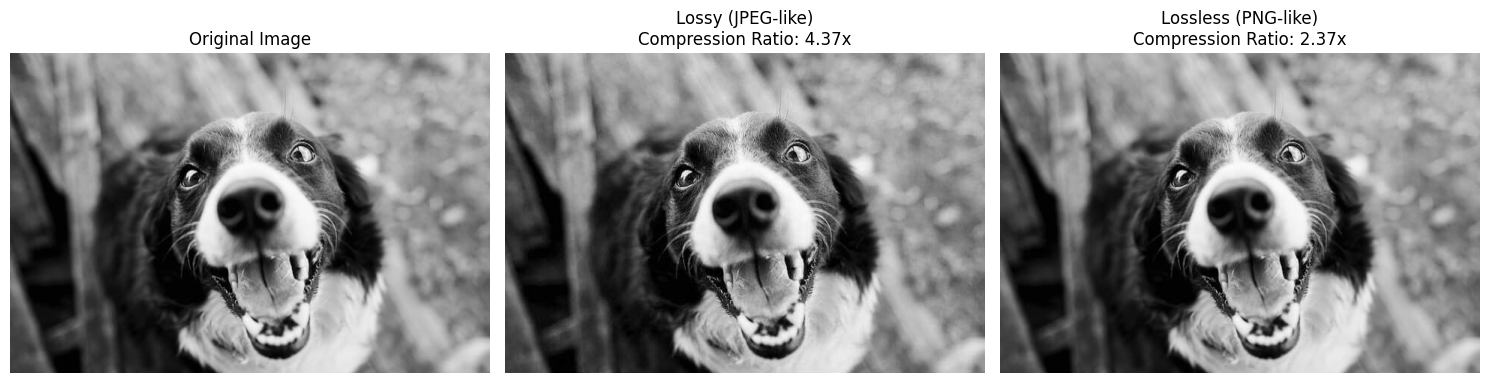

Lossy Compression Ratio: 4.37x
Lossless Compression Ratio: 2.37x


In [ ]:

# Function to perform block-wise DCT
def blockwise_dct(image, block_size=8):
    """Applies DCT block-wise to an image."""
    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)

    # Process the image in block sizes
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            # Apply DCT to the block
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image

# Function to perform block-wise Inverse DCT
def blockwise_idct(dct_image, block_size=8):
    """Applies Inverse DCT block-wise to an image."""
    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)

    # Process the DCT image in block sizes
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            # Apply Inverse DCT to the block
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block

    return image_reconstructed

# Function to apply quantization to the DCT coefficients (block-wise)
def blockwise_quantize_dct(dct_image, quant_matrix, block_size=8):
    """Quantizes the DCT coefficients block-wise."""
    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i + block_size, j:j + block_size]
            quantized_block = np.round(block / quant_matrix)  # Quantization
            quantized_dct[i:i + block_size, j:j + block_size] = quantized_block

    return quantized_dct

# Function to dequantize the DCT coefficients (block-wise)
def blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size=8):
    """Dequantizes the DCT coefficients block-wise."""
    h, w = quantized_dct.shape
    dequantized_dct = np.zeros_like(quantized_dct)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct[i:i + block_size, j:j + block_size]
            dequantized_block = block * quant_matrix  # Dequantization
            dequantized_dct[i:i + block_size, j:j + block_size] = dequantized_block

    return dequantized_dct

# Function to perform lossy compression (JPEG-like)
def lossy_compression(image, quality=50, block_size=8):
    """
    Perform JPEG-like lossy compression using DCT and quantization.

    Parameters:
    - image: Input grayscale image
    - quality: Compression quality (0-100, lower means more compression)
    - block_size: Size of the blocks for DCT (usually 8x8)

    Returns:
    - compressed_image: Reconstructed image after compression
    - compression_ratio: Ratio of original size to compressed size
    """
    # Make a copy of the image
    img = image.copy()

    # Pad the image to make its dimensions a multiple of block_size
    h, w = img.shape
    new_h = ((h + block_size - 1) // block_size) * block_size
    new_w = ((w + block_size - 1) // block_size) * block_size
    padded_image = cv2.copyMakeBorder(img, 0, new_h - h, 0, new_w - w,
                                      cv2.BORDER_CONSTANT, value=0)

    # Define standard JPEG quantization matrix
    base_quant_matrix = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])

    # Adjust quantization matrix based on quality
    if quality < 50:
        scale = 5000 / quality
    else:
        scale = 200 - 2 * quality

    quant_matrix = np.floor((base_quant_matrix * scale + 50) / 100)
    quant_matrix = np.clip(quant_matrix, 1, 255).astype(np.float32)

    # Apply block-wise DCT
    dct_image = blockwise_dct(padded_image, block_size)

    # Quantize the DCT coefficients
    quantized_dct = blockwise_quantize_dct(dct_image, quant_matrix, block_size)

    # Calculate size of quantized data (approximation)
    original_size = padded_image.size * padded_image.itemsize
    compressed_size = np.count_nonzero(quantized_dct) * 2  # Assuming 2 bytes per non-zero value

    # Dequantize to get the approximate DCT coefficients
    dequantized_dct = blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size)

    # Reconstruct the image using block-wise IDCT
    image_reconstructed = blockwise_idct(dequantized_dct, block_size)

    # Crop back to original size
    image_reconstructed = image_reconstructed[:h, :w]

    # Clip values to be in the 8-bit range and convert to uint8
    image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

    # Calculate compression ratio
    if compressed_size > 0:
        compression_ratio = original_size / compressed_size
    else:
        compression_ratio = float('inf')

    return image_reconstructed, compression_ratio

# Function to perform lossless compression (PNG-like)
def lossless_compression(image):
    """
    Perform lossless compression similar to PNG.

    Parameters:
    - image: Input grayscale image

    Returns:
    - compressed_image: Same as input (no quality loss)
    - compression_ratio: Ratio of original size to compressed size
    """
    # Convert image to PIL Image
    pil_img = Image.fromarray(image)

    # Save image to PNG in-memory
    buffer = io.BytesIO()
    pil_img.save(buffer, format="PNG")

    # Get the size of the compressed image
    compressed_size = buffer.tell()

    # Calculate original size
    original_size = image.size * image.itemsize

    # Calculate compression ratio
    compression_ratio = original_size / compressed_size

    # For lossless compression, the output image is identical to the input
    return image, compression_ratio

# Function to display comparison
def display_compression_comparison(original, lossy, lossless, lossy_ratio, lossless_ratio):
    """Display original image alongside compressed versions with metrics."""
    plt.figure(figsize=(15, 5))

    # Plot original image
    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot lossy compressed image
    plt.subplot(1, 3, 2)
    plt.imshow(lossy, cmap='gray')
    plt.title(f'Lossy (JPEG-like)\nCompression Ratio: {lossy_ratio:.2f}x')
    plt.axis('off')

    # Plot lossless compressed image
    plt.subplot(1, 3, 3)
    plt.imshow(lossless, cmap='gray')
    plt.title(f'Lossless (PNG-like)\nCompression Ratio: {lossless_ratio:.2f}x')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Main function to demonstrate both compression methods
def main(image_path):
    # Load the image in grayscale mode
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    # Perform lossy compression (JPEG-like)
    lossy_image, lossy_ratio = lossy_compression(image, quality=50)

    # Perform lossless compression (PNG-like)
    lossless_image, lossless_ratio = lossless_compression(image)

    # Display the results
    display_compression_comparison(image, lossy_image, lossless_image, lossy_ratio, lossless_ratio)

    # Print compression statistics
    print(f"Lossy Compression Ratio: {lossy_ratio:.2f}x")
    print(f"Lossless Compression Ratio: {lossless_ratio:.2f}x")

# Usage example
if __name__ == "__main__":
    # Replace with your image path
    image_path = "/content/rgb_image.jpg"
    main(image_path)

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Train and evaluate CNN on MNIST
mnist_model = build_cnn((28,28,1), 10)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
mnist_model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
mnist_eval = mnist_model.evaluate(x_test, y_test)
print("MNIST Accuracy:", mnist_eval[1])


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 44s 55ms/step - accuracy: 0.8233 - loss: 0.5620 - val_accuracy: 0.9822 - val_loss: 0.0610
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - accuracy: 0.9710 - loss: 0.0969 - val_accuracy: 0.9865 - val_loss: 0.0451
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - accuracy: 0.9791 - loss: 0.0679 - val_accuracy: 0.9866 - val_loss: 0.0444
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 58ms/step - accuracy: 0.9840 - loss: 0.0545 - val_accuracy: 0.9887 - val_loss: 0.0400
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 79s 55ms/step - accuracy: 0.9873 - loss: 0.0419 - val_accuracy: 0.9881 - val_loss: 0.0415
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - accuracy: 0.9884 - loss: 0.0373 - val_accuracy: 0.9905 - val_loss: 0.0343
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 59ms/step - accuracy: 0.9900 - loss: 0.0303 - val_accuracy: 0.9910 - val_loss: 0.0351
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 78s 55ms/step - accuracy: 0.9914 - loss: 0.0273 - 

KeyboardInterrupt: 

In [ ]:
# Load and preprocess CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Train and evaluate CNN on CIFAR-10
cifar_model = build_cnn((32,32,3), 10)
early_stopping_cifar = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
cifar_model.fit(x_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping_cifar])
cifar_eval = cifar_model.evaluate(x_test, y_test)
print("CIFAR-10 Accuracy:", cifar_eval[1])


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - accuracy: 0.2803 - loss: 1.9416 - val_accuracy: 0.5051 - val_loss: 1.3879
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 82ms/step - accuracy: 0.4767 - loss: 1.4495 - val_accuracy: 0.5655 - val_loss: 1.2374
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.5307 - loss: 1.3048 - val_accuracy: 0.5926 - val_loss: 1.1665
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 82ms/step - accuracy: 0.5684 - loss: 1.2225 - val_accuracy: 0.6253 - val_loss: 1.0876
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.5978 - loss: 1.1325 - val_accuracy: 0.6412 - val_loss: 1.0334
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 84ms/step - accuracy: 0.6157 - loss: 1.0848 - val_accuracy: 0.6521 - val_loss: 1.0114
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.6362 - loss: 1.0300 - val_accuracy: 0.6657 - val_loss: 0.9664
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
Classification Report (CIFAR):
               precision    recall  f1-score   support

           0       0.71      0.77      0.74      1000
           1       0.85      0.79      0.82      1000
           2       0.59      0.51      0.55      1000
           3       0.48      0.53      0.50      1000
           4       0.62      0.68      0.65      1000
           5       0.60      0.60      0.60      1000
           6       0.79      0.73      0.76      1000
           7       0.72      0.77      0.75      1000
           8       0.80      0.78      0.79      1000
           9       0.79      0.77      0.78      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



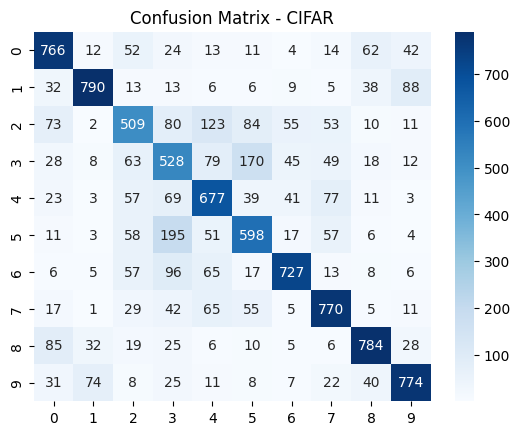

In [ ]:
# Generate classification metrics for MNIST
y_pred = np.argmax(cifar_model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report (CIFAR):\n", classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - CIFAR")
plt.show()